In [55]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,r2_score

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [56]:
df = pd.read_csv('AmesHousing.csv')
data = df.drop(['PID'], axis=1)

In [57]:
data = data.rename(columns={"MS SubClass": "MSSubClass", "MS Zoning": "MSZoning",'Lot Frontage':'LotFrontage', 'Lot Area':'LotArea',
       'Sale Condition':'SaleCondition','Yr Sold':'YrSold','YearBuilt': 'YearBuilt', 'Gr Liv Area': 'GrLivArea', 'Garage Area':'GarageArea',
       'Year Built':'YearBuilt','Pool Area':'PoolArea','Year Remod/Add':'YearRemodAdd'
})

In [58]:
liste_to_numeric = ['YrSold', 'YearBuilt', 'GrLivArea', 'LotFrontage', 'LotArea','GarageArea']
data[liste_to_numeric] = data[liste_to_numeric].apply(pd.to_numeric)

In [59]:
data = data*1

Data cleaning

In [60]:
# create dumies
data['Fence'] = data['Fence'].notna()
data['Pool'] = data['PoolArea'] > 0

# create the new variable 'age'
data['Age'] = data.apply(lambda x: x['YrSold']-x['YearBuilt'] if (x['YearBuilt']<x['YearRemodAdd']) 
                                                           else (x['YrSold']-x['YearRemodAdd']), axis=1)

# Delete all data with MSZoning = commercial, agriculture and industrial as these are not residential units
data = data[(data.MSZoning != 'C (all)') & (data.MSZoning != 'I (all)') & (data.MSZoning != 'A (agr)')]

# Delete abnormal sales
data = data[(data.SaleCondition != 'Abnorml')] 
data = data[(data.SaleCondition != 'Family')] 


In [61]:
X_valid=pd.read_csv("x_valid.csv")
y_valid=pd.read_csv("y_valid.csv")

In [62]:
df = pd.merge(data, X_valid, how='outer', indicator=True)

In [63]:
df2 = df.loc[df._merge == 'left_only']

In [64]:
data = df2.drop("_merge",axis=1)

In [65]:
# Select Features
X_train = data[['Age','GrLivArea', 'LotFrontage', 'LotArea', 'GarageArea', 'Fence', 'Pool']]
y_train = data[['SalePrice']]

In [66]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=.3, random_state=1121218)

Entrainement du model

In [67]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

In [68]:
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [69]:
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

In [70]:
randomf = RandomForestRegressor()

randomf_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', randomf)
])

In [71]:
from sklearn.model_selection import GridSearchCV

param_dict = {'model__n_estimators': [350,400,450,500], 'model__bootstrap': [True,False]}

search = GridSearchCV(randomf_pipeline, param_dict, 
                      cv=10, 
                      scoring='neg_mean_absolute_error')

_ = search.fit(X_train, y_train)

print('Best score:', abs(search.best_score_))

print('Best params:', search.best_params_)

C:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-

Best score: 22861.207247368322
Best params: {'model__bootstrap': True, 'model__n_estimators': 350}


In [72]:
import pickle
filename = 'more_data_model.sav'
pickle.dump(search, open(filename, 'wb'))

Evaluation du modele

In [73]:
new_model = pickle.load(open("more_data_model.sav", 'rb'))

In [74]:
predict_on_Xtrain = new_model.predict(X_train)
predict_on_Xvalid = new_model.predict(X_valid)

In [75]:
r2_train = r2_score(y_train,predict_on_Xtrain)
r2_valid = r2_score(y_valid,predict_on_Xvalid)
mae_train = mean_absolute_error(y_train,predict_on_Xtrain)
mae_valid = mean_absolute_error(y_valid,predict_on_Xvalid)

In [76]:
print("EVALUATION DU MODELE GRACE A LA MAE (Mean Absolute Error)")
print("    ")
print("SUR LES DONNEES D'ENTRAINEMENT:")
print("Le modèle prédit une valeur exacte avec une erreure moyenne de {}$, ce qui est un delta acceptable sur le prix d'un bien immobilier".format(round(mae_train)))
print("    ")
print("SUR LES DONNEES DE VALIDATION:")
print("Le modèle prédit une valeur exacte et ce avec une erreure moyenne de {}$, ce qui n'est plus acceptable".format(round(mae_valid)))
print("    ")
print("CONCLUSION:")
print("l'écart de performance des predictions est trop imortant,")
print("celui ci est bien plus performant sur les données d'entrainement que sur les données de validation")
print("on constate un overfitting du model")

EVALUATION DU MODELE GRACE A LA MAE (Mean Absolute Error)
    
SUR LES DONNEES D'ENTRAINEMENT:
Le modèle prédit une valeur exacte avec une erreure moyenne de 8204$, ce qui est un delta acceptable sur le prix d'un bien immobilier
    
SUR LES DONNEES DE VALIDATION:
Le modèle prédit une valeur exacte et ce avec une erreure moyenne de 21973$, ce qui n'est plus acceptable
    
CONCLUSION:
l'écart de performance des predictions est trop imortant,
celui ci est bien plus performant sur les données d'entrainement que sur les données de validation
on constate un overfitting du model


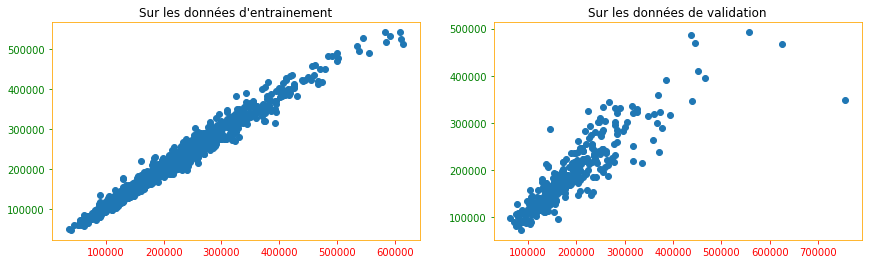

In [77]:
with plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'red', 'ytick.color':'green', 'figure.facecolor':'white'}):
    fig, (ax1, ax2) = plt.subplots(1,2)
    plt.subplots_adjust(right=2)

    ax1.scatter(y_train,predict_on_Xtrain)
    ax1.set_title("Sur les données d'entrainement")

    ax2.scatter(y_valid,predict_on_Xvalid)
    ax2.set_title("Sur les données de validation")